# EDA Group 7 Code Submission

## Work of all group members, compiled into Jupyter Notebook after work is done in python using Spyder. 
## All code that was written by group members can be found on [this Github repository](https://github.com/jichuan-zhang/ESDA_0091_assignment)

## Section 1 Data Cleaning
This section is described in the essay submitted in section 3.3 Data Cleaning

Data and failure logs are imported. 

Failure durations are  decided using the following rule: 
Starting from the time of failure logged, look forwards and backwards for continuous positive power generation, the moment of sign change is decided as the start and end time of those failure. 
The time in between are removed as outliers.

The NaN values are dropped. 

The wind direction in degrees is converted into sine and cosine componenets. 

Turbine ID are dropped as all turbines are the same.
Time are dropped as this analysis focuses on short term prediction, therefore it is not a times series problem. 

Cleaned Data is exported. 

In [1]:
# Import Libraries and Load Data
import pandas as pd
import numpy as np

# This was used in python to make sure code works on all group member's computer
# import os
# os.chdir(os.path.dirname(os.path.abspath(__file__)))

scada_data_path = 'Wind-Turbine-SCADA-signals-2017_modified.csv'
failures_data_path = 'opendata-wind-failures-2017.csv'

scada_data = pd.read_csv(scada_data_path, parse_dates=['Timestamp'])
failures_data = pd.read_csv(failures_data_path, parse_dates=['Timestamp'])

clean_data = pd.DataFrame()

# Sort SCADA Data
scada_data_sorted = scada_data.sort_values(by=['Turbine_ID', 'Timestamp']).reset_index(drop=True)

# Process Each Turbine
for turbine in scada_data_sorted['Turbine_ID'].unique():
    turbine_scada_data = scada_data_sorted[scada_data_sorted['Turbine_ID'] == turbine].reset_index(drop=True)
    turbine_failures = failures_data[failures_data['Turbine_ID'] == turbine]

    if turbine_failures.empty:
        # If there are no failures for this turbine, append its data as is
        clean_data = pd.concat([clean_data, turbine_scada_data], ignore_index=True)
    else:
        # Process Each Failure
        for _, failure in turbine_failures.iterrows():
            # Rounding failure timestamp to the nearest 10 minutes
            rounded_failure_time = failure['Timestamp'].round('10min')
            nearest_index = turbine_scada_data['Timestamp'].sub(rounded_failure_time).abs().idxmin()
    
            # Initialize start and end indices for the failure
            start_index, end_index = nearest_index, nearest_index
    
            # Look Backward to Find Start of Failure
            consecutive_positives = 0
            for i in range(nearest_index, 0, -1):
                if turbine_scada_data.iloc[i]['Prod_LatestAvg_TotActPwr'] > 0:
                    consecutive_positives += 1
                    if consecutive_positives == 5:
                        start_index = i + consecutive_positives  # Corrected start index
                        break
                else:
                    consecutive_positives = 0  # Reset if a non-positive value is found
            
            # Look Forward to Find End of Failure
            consecutive_positives = 0
            for i in range(nearest_index, len(turbine_scada_data)):
                if turbine_scada_data.iloc[i]['Prod_LatestAvg_TotActPwr'] > 0:
                    consecutive_positives += 1
                    if consecutive_positives == 5:
                        end_index = i + consecutive_positives  # Corrected end index
                        break
                else:
                    consecutive_positives = 0  # Reset if a non-positive value is found
    
            # Exclude Failure Period
            if start_index >= 0 and end_index < len(turbine_scada_data):
                start_time = turbine_scada_data.iloc[start_index]['Timestamp']
                end_time = turbine_scada_data.iloc[end_index]['Timestamp']
                turbine_scada_data = turbine_scada_data[
                    ~((turbine_scada_data['Timestamp'] >= start_time) &
                      (turbine_scada_data['Timestamp'] <= end_time))
                ]
    
        # Append Cleaned Data for This Turbine
        clean_data = pd.concat([clean_data, turbine_scada_data], ignore_index=True)

# Drop NaN Values
rows_before_drop = len(clean_data)
clean_data.dropna(inplace=True)
rows_after_drop = len(clean_data)
rows_dropped = rows_before_drop - rows_after_drop

print(f"Number of rows before dropping NaNs: {rows_before_drop}")
print(f"Number of rows after dropping NaNs: {rows_after_drop}")
print(f"Number of rows dropped: {rows_dropped}")

# Convert Direction to Sine and Cosine
clean_data['Amb_WindDir_Abs_Avg_sin'] = np.sin(np.radians(clean_data['Amb_WindDir_Abs_Avg']))
clean_data['Amb_WindDir_Abs_Avg_cos'] = np.cos(np.radians(clean_data['Amb_WindDir_Abs_Avg']))
clean_data.drop('Amb_WindDir_Abs_Avg', axis=1, inplace=True)


# Save Clean Data
cols_to_exclude = ['Turbine_ID', 'Timestamp']
clean_data.loc[:, ~clean_data.columns.isin(cols_to_exclude)].to_csv('cleaned_data.csv', index=False)

Number of rows before dropping NaNs: 207675
Number of rows after dropping NaNs: 207671
Number of rows dropped: 4


## Section 2 Training
This section is a more detailed presentaion of section 4 Methods in the submitted essay. 

First all relavent functions are installed and imported. MAPE is not a seperate function in sklearn.metrics, therefore a custom one is produced. 

The data is loaded and splitted. A fixed random state was used to ensure reproducibility when group members working seperately on their algorithium. 

For ANN and SVR the data is further scaled using StandardScaler to improve the model performance, as those methods are sensitive to relative magnitude of features. 

The training is done using GridSearchCV which does the training with different hyperparameter and determine best combination using a **matric of user's choice**. Here the MSE is chosen as explained very detailed in the essay section 4.1. 

The code presented here is the snapshot of final tuning process, in reality the grid is adjusted many times to ensure best model performance. Due to the need of further processing, a even more simplified version of the grid is used just to demonstrate the process, as the best set of hyperparameter was already known. 

The R-squared, MSE, MAPE, MAE are calculated after model has been trained with best hyperparameters. 

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def mean_absolute_percentage_error(y_test, predictions): 
    y_test, y_pred = np.array(y_test), np.array(predictions)
    return np.mean(np.abs((y_test - predictions) / y_test)) * 100

In [4]:
# Load data
data = pd.read_csv('cleaned_data.csv')
X = data.drop('Prod_LatestAvg_TotActPwr', axis=1)
y = data['Prod_LatestAvg_TotActPwr']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print out shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (166136, 7)
X_test shape: (41535, 7)
y_train shape: (166136,)
y_test shape: (41535,)


In [5]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor()

# Setup the parameter grid
param_grid_rf = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_

# Evaluate the model
# Make predictions on the test set
predictions_rf = best_rf.predict(X_test)

# Calculate different matrics
mse_rf = mean_squared_error(y_test, predictions_rf)
r_squared_rf = r2_score(y_test, predictions_rf)
mae_rf = mean_absolute_error(y_test, predictions_rf)
mape_rf = mean_absolute_percentage_error(y_test, predictions_rf)

print(f'Mean Squared Error: {mse_rf}')
print(f'R-squared: {r_squared_rf}')
print(f'Mean Absolute Error: {mae_rf}')
print(f'Mean Absolute Percentage Error: {mape_rf}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Mean Squared Error: 29187207.955969017
R-squared: 0.9976952410864075
Mean Absolute Error: 3201.7085782175322
Mean Absolute Percentage Error: 28.0182755429547


In [6]:
# Initialize XGBoost Regressor
xgb = XGBRegressor()

# Setup the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    'subsample': [0.7, 0.8, 0.9, 1]
}

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit the model
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_

# %% Evaluate the model
# Make predictions on the test set
predictions_xgb = best_xgb.predict(X_test)

# Calculate different matrics
mse_xgb = mean_squared_error(y_test, predictions_xgb)
r_squared_xgb = r2_score(y_test, predictions_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, predictions_xgb)

print(f'Mean Squared Error: {mse_xgb}')
print(f'R-squared: {r_squared_xgb}')
print(f'Mean Absolute Error: {mae_xgb}')
print(f'Mean Absolute Percentage Error: {mape_xgb}')

Fitting 3 folds for each of 320 candidates, totalling 960 fits
Best parameters found:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.9}
Mean Squared Error: 27529806.44650358
R-squared: 0.9978261172876566
Mean Absolute Error: 3133.4223381140573
Mean Absolute Percentage Error: 29.826791060013335


In [7]:
# Initialize Gradient Boost
gbr = GradientBoostingRegressor(random_state=42)

# The block commented below is what was used during tuning, however it is taking too long to repreduce
# Therefore a simplified version of the parameter grid is used instead in the document

# # Setup the parameter grid for Gradient Boost
# param_grid_gbr = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }

param_grid_gbr = {
    'n_estimators': [300],
    'learning_rate': [0.1, 0.2],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_depth': [5],
    'max_features': ['sqrt', None]
}

# Initialize GridSearchCV
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit the model
grid_search_gbr.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search_gbr.best_params_)
best_gbr = grid_search_gbr.best_estimator_

# %% Evaluate the model
# Make predictions on the test set
predictions_gbr = best_gbr.predict(X_test)

# Calculate different matrics
mse_gbr = mean_squared_error(y_test, predictions_gbr)
r_squared_gbr = r2_score(y_test, predictions_gbr)
mae_gbr = mean_absolute_error(y_test, predictions_gbr)
mape_gbr = mean_absolute_percentage_error(y_test, predictions_gbr)

print(f'Mean Squared Error: {mse_gbr}')
print(f'R-squared: {r_squared_gbr}')
print(f'Mean Absolute Error: {mae_gbr}')
print(f'Mean Absolute Percentage Error: {mape_gbr}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Mean Squared Error: 28128554.00626138
R-squared: 0.9977788373704605
Mean Absolute Error: 3184.635746506917
Mean Absolute Percentage Error: 30.962195857058326


In [8]:
# Standardize the data (important for ANN and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Initialize ANN regressor
ann_regressor = MLPRegressor(max_iter=1000)

# The block commented below is what was used during tuning, however it is taking too long to repreduce
# Therefore a simplified version of the parameter grid is used instead in the document

# # Setup the parameter grid for ANN
# param_grid_ann = {
#     'hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam'],
#     'alpha': [0.0001, 0.001],
#     'learning_rate_init': [0.001, 0.01],
#     'beta_1': [0.9, 0.95],  # Adjusted beta_1
#     'beta_2': [0.999, 0.995],  # Adjusted beta_2
# }

param_grid_ann = {
    'hidden_layer_sizes': [(100, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate_init': [0.001, 0.01],
    'beta_1': [0.9, 0.95],  # Adjusted beta_1
    'beta_2': [0.999, 0.995],  # Adjusted beta_2
}

# Initialize GridSearchCV
grid_search_ann = GridSearchCV(estimator=ann_regressor, param_grid=param_grid_ann, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit the model
grid_search_ann.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found: ", grid_search_ann.best_params_)
best_ann = grid_search_ann.best_estimator_

# %% Evaluate the model
# Make predictions on the test set
predictions_ann = best_ann.predict(X_test_scaled)

# Calculate different matrics
mse_ann = mean_squared_error(y_test, predictions_ann)
r_squared_ann = r2_score(y_test, predictions_ann)
mae_ann = mean_absolute_error(y_test, predictions_ann)
mape_ann = mean_absolute_percentage_error(y_test, predictions_ann)

print(f'Mean Squared Error: {mse_ann}')
print(f'R-squared: {r_squared_ann}')
print(f'Mean Absolute Error: {mae_ann}')
print(f'Mean Absolute Percentage Error: {mape_ann}')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
Mean Squared Error: 29996724.97326697
R-squared: 0.9976313178237187
Mean Absolute Error: 3304.4341191801586
Mean Absolute Percentage Error: 32.40597648391935


In [10]:
# Initialize SVR
svr = SVR()

# The block commented below is what was used during tuning, however it is taking too long to repreduce
# Therefore a simplified version of the parameter grid is used instead in the document

# param_grid_svr = {
# 'C': [50000,100000,200000], # Consider a wider range and more values
# 'gamma': ['scale', 'auto'], # More options for gamma
# 'kernel': ['poly', 'rbf'], # Try different kernels
# 'epsilon': [500, 1000] # Include epsilon in the search
# }

param_grid_svr = {
'C': [50000], # Consider a wider range and more values
'gamma': ['scale', 'auto'], # More options for gamma
'kernel': ['poly', 'rbf'], # Try different kernels
'epsilon': [1000] # Include epsilon in the search
}

# Initialize GridSearchCV
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit the model
grid_search_svr.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found: ", grid_search_svr.best_params_)
best_svr = grid_search_svr.best_estimator_

# %% Evaluate the model
# Make predictions on the test set
predictions_svr = best_svr.predict(X_test_scaled)

# Calculate different matrics
mse_svr = mean_squared_error(y_test, predictions_svr)
r_squared_svr = r2_score(y_test, predictions_svr)
mae_svr = mean_absolute_error(y_test, predictions_svr)
mape_svr = mean_absolute_percentage_error(y_test, predictions_svr)

print(f'Mean Squared Error: {mse_svr}')
print(f'R-squared: {r_squared_svr}')
print(f'Mean Absolute Error: {mae_svr}')
print(f'Mean Absolute Percentage Error: {mape_svr}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters found:  {'C': 50000, 'epsilon': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Squared Error: 33421193.871577304
R-squared: 0.9973609056887311
Mean Absolute Error: 3488.814584988839
Mean Absolute Percentage Error: 41.97391123192122


## Section 3 Visualisation
This sections produces all the graphs used in the essay. (Some are later decided to be omitted.)

First a subset of 2000 is generated from the 200 thousand rows of the whole dataset, the validity of the subset is checkde by comparing mean, median and mean of the features, and they are sufficiently similar. 

Then exploratory analysis of different features against the power generation is plotted. 

Full dataset statistics:
Mean:
 Rtr_RPM_Avg                     9.661641
Amb_WindSpeed_Avg               6.115423
Amb_Temp_Avg                   20.148403
Prod_LatestAvg_TotActPwr    93082.275262
Blds_PitchAngle_Avg             7.485996
Grd_Prod_CosPhi_Avg             0.854245
Amb_WindDir_Abs_Avg_sin         0.223830
Amb_WindDir_Abs_Avg_cos        -0.046143
dtype: float64
Median:
 Rtr_RPM_Avg                    11.300000
Amb_WindSpeed_Avg               5.400000
Amb_Temp_Avg                   20.000000
Prod_LatestAvg_TotActPwr    40951.000000
Blds_PitchAngle_Avg            -0.300000
Grd_Prod_CosPhi_Avg             0.900000
Amb_WindDir_Abs_Avg_sin         0.676876
Amb_WindDir_Abs_Avg_cos        -0.097583
dtype: float64
Variance:
 Rtr_RPM_Avg                 2.906671e+01
Amb_WindSpeed_Avg           1.323439e+01
Amb_Temp_Avg                3.221639e+01
Prod_LatestAvg_TotActPwr    1.259056e+10
Blds_PitchAngle_Avg         2.062568e+02
Grd_Prod_CosPhi_Avg         3.116375e-02
Amb_WindDir_Abs_

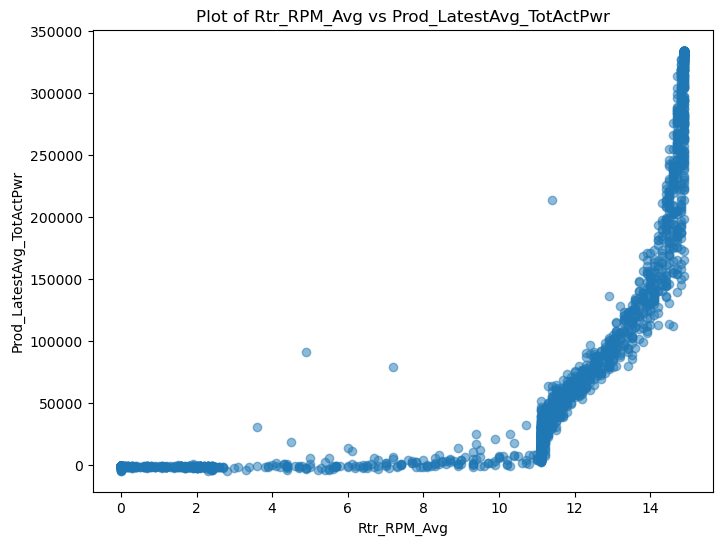

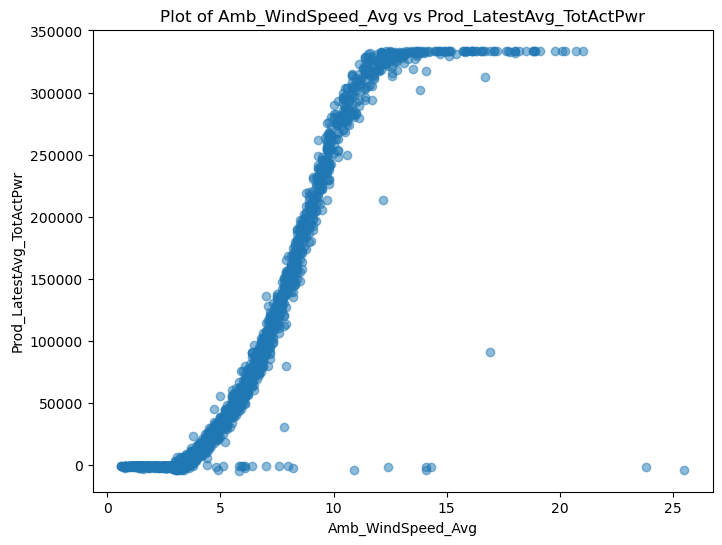

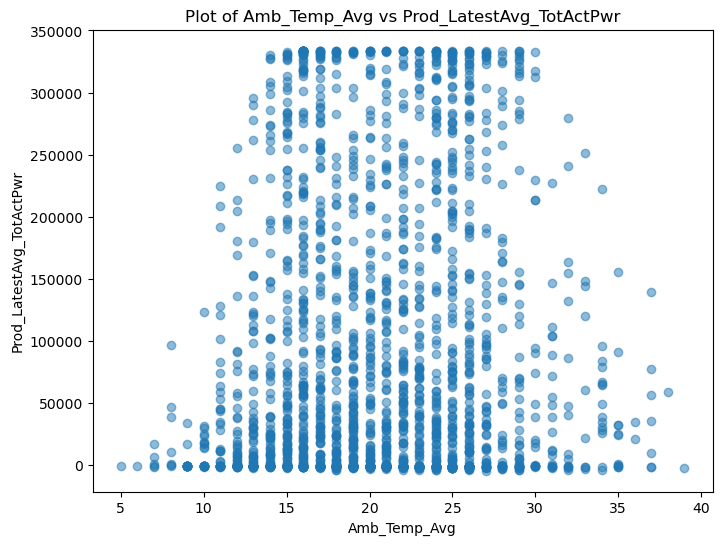

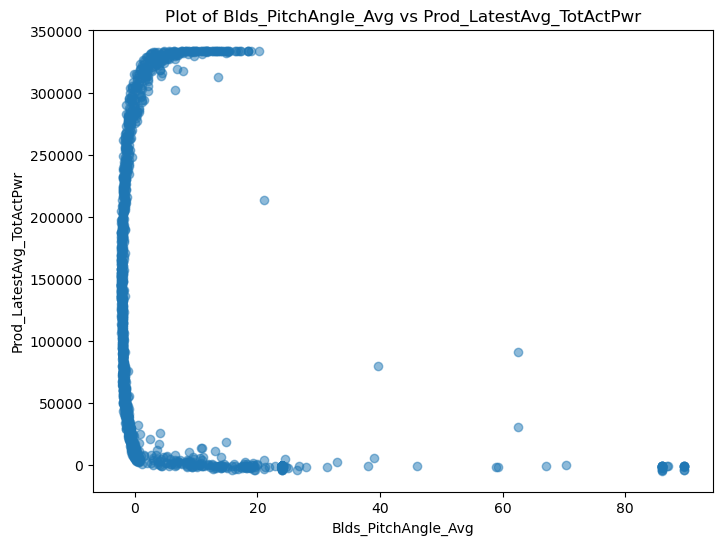

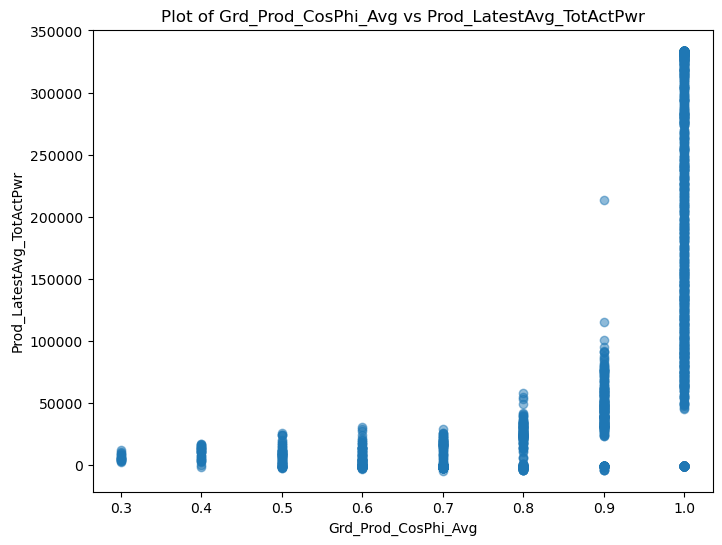

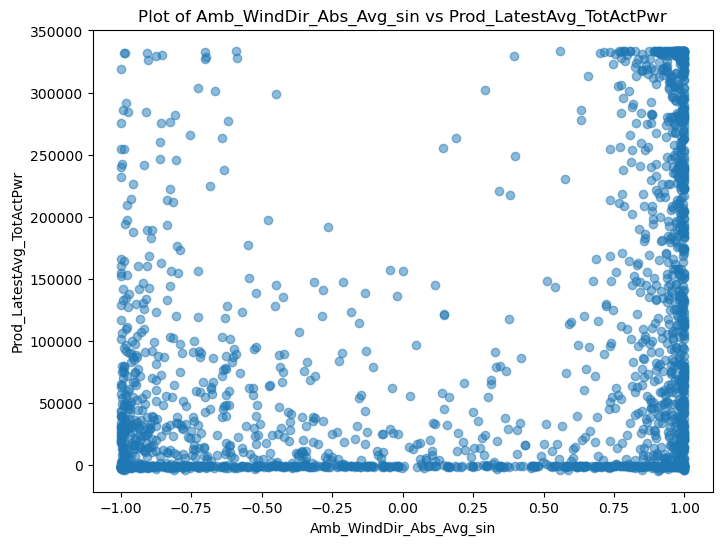

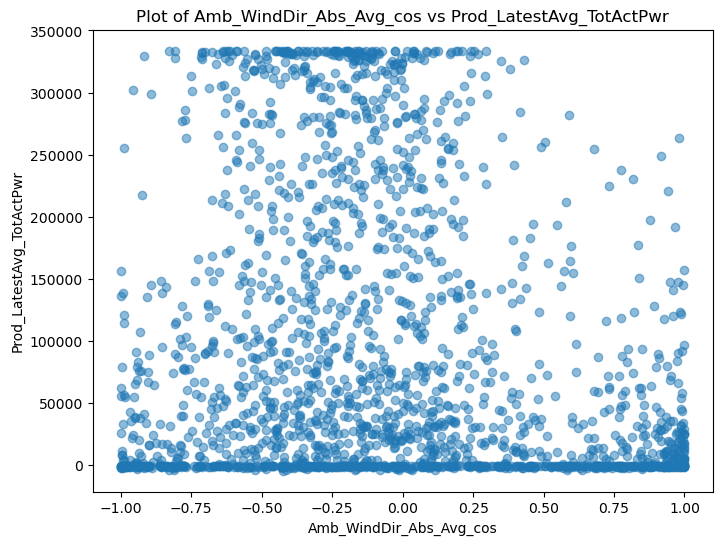

In [11]:
# Create a subset data_sub by randomly choosing 2000 rows
data_sub = data.sample(n=2000)

# Check and print the mean, median, variance for data and data_sub
print("Full dataset statistics:")
print("Mean:\n", data.mean())
print("Median:\n", data.median())
print("Variance:\n", data.var())

print("\nSubset dataset statistics:")
print("Mean:\n", data_sub.mean())
print("Median:\n", data_sub.median())
print("Variance:\n", data_sub.var())

# Split the data_sub into X_sub and y_sub
X_sub = data_sub.drop('Prod_LatestAvg_TotActPwr', axis=1)
y_sub = data_sub['Prod_LatestAvg_TotActPwr']

# Plot each column in X_sub against y_sub
for column in X_sub.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_sub[column], y_sub, alpha=0.5)
    plt.title(f"Plot of {column} vs Prod_LatestAvg_TotActPwr")
    plt.xlabel(column)
    plt.ylabel('Prod_LatestAvg_TotActPwr')
    plt.show()

Here bar plots of different metrics of different models are plotted for a better visualisation

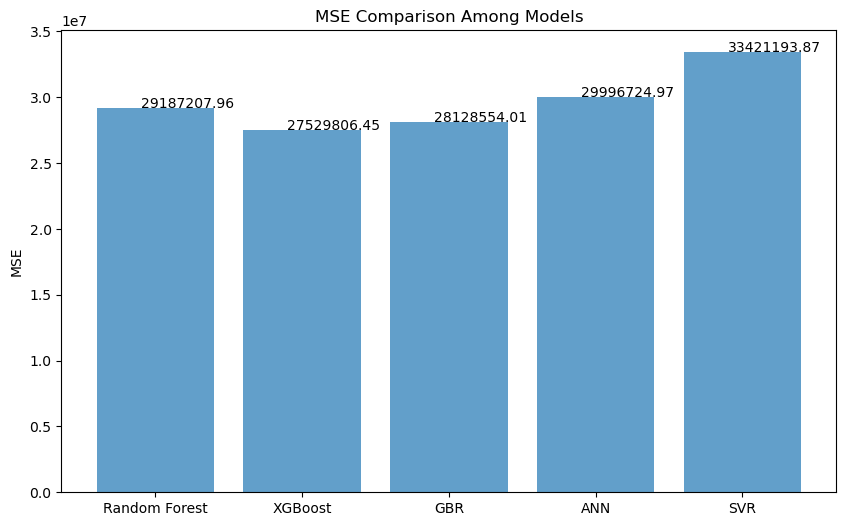

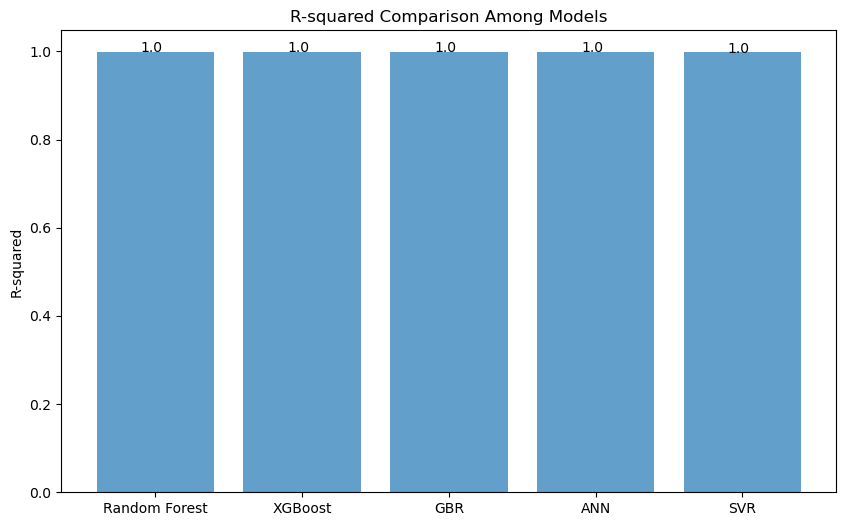

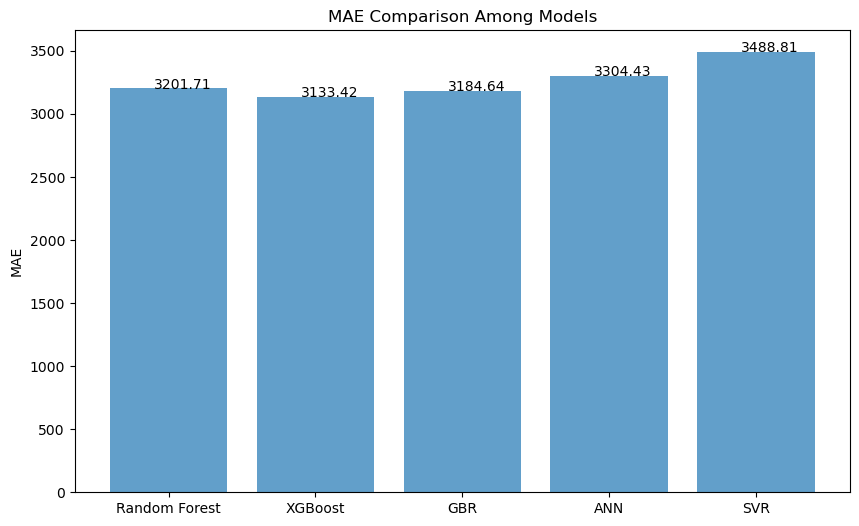

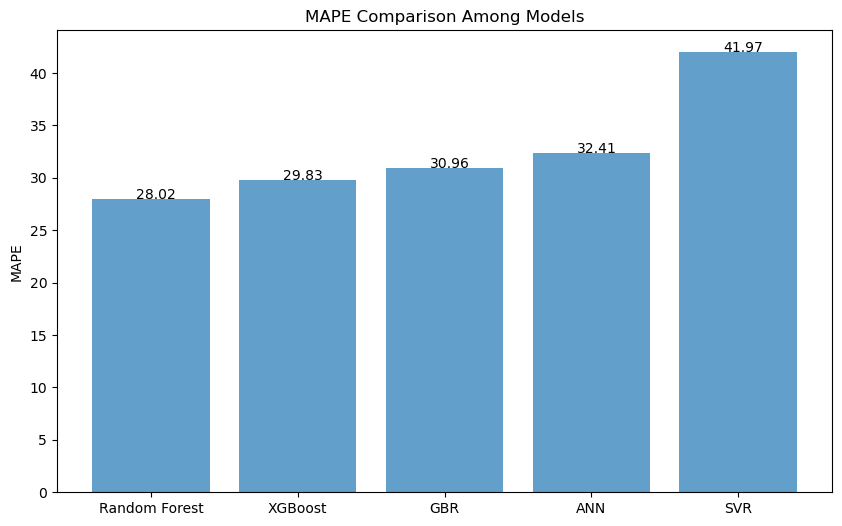

In [12]:
# Metrics for each model
models = ['Random Forest', 'XGBoost', 'GBR', 'ANN', 'SVR']
mse_values = [mse_rf, mse_xgb, mse_gbr, mse_ann, mse_svr]
r_squared_values = [r_squared_rf, r_squared_xgb, r_squared_gbr, r_squared_ann, r_squared_svr]
mae_values = [mae_rf, mae_xgb, mae_gbr, mae_ann, mae_svr]
mape_values = [mape_rf, mape_xgb, mape_gbr, mape_ann, mape_svr]

# Function to create a bar plot
def create_bar_plot(values, metric_name):
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(models))
    plt.bar(y_pos, values, align='center', alpha=0.7)
    plt.xticks(y_pos, models)
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison Among Models')

    for i in range(len(values)):
        plt.text(x = y_pos[i] - 0.1, y = values[i], s = round(values[i], 2), size = 10)

    plt.show()

# Create bar plots
create_bar_plot(mse_values, 'MSE')
create_bar_plot(r_squared_values, 'R-squared')
create_bar_plot(mae_values, 'MAE')
create_bar_plot(mape_values, 'MAPE')


Here a subset of 1000 is generated from the 40 thousand y_test dataframe, as well as the 5 different predictions.

To ensure the subset is the same, 1000 different indices are chosen at random, with a set seed to ensure reproducibility. 

The subset is generated using the chosen indices. Then plots of prediction against actual values are made to visulise the performance of models. 

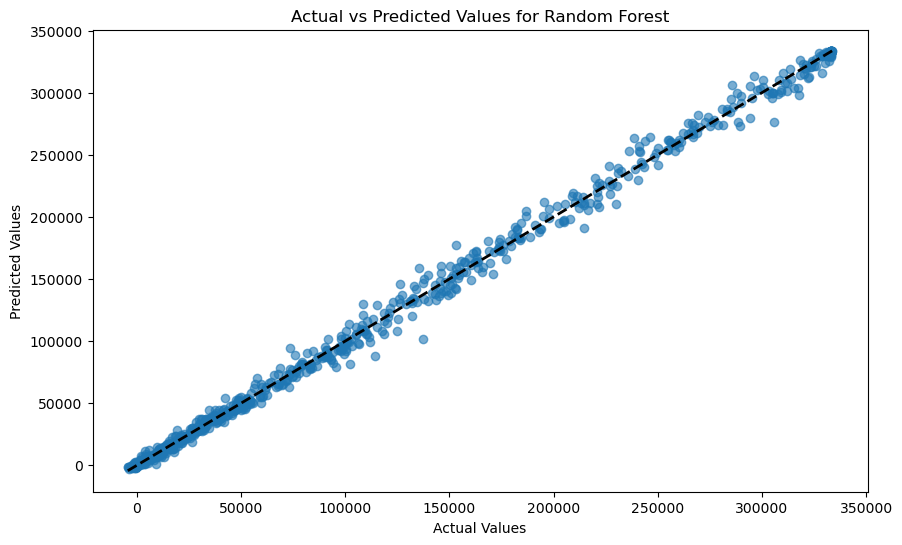

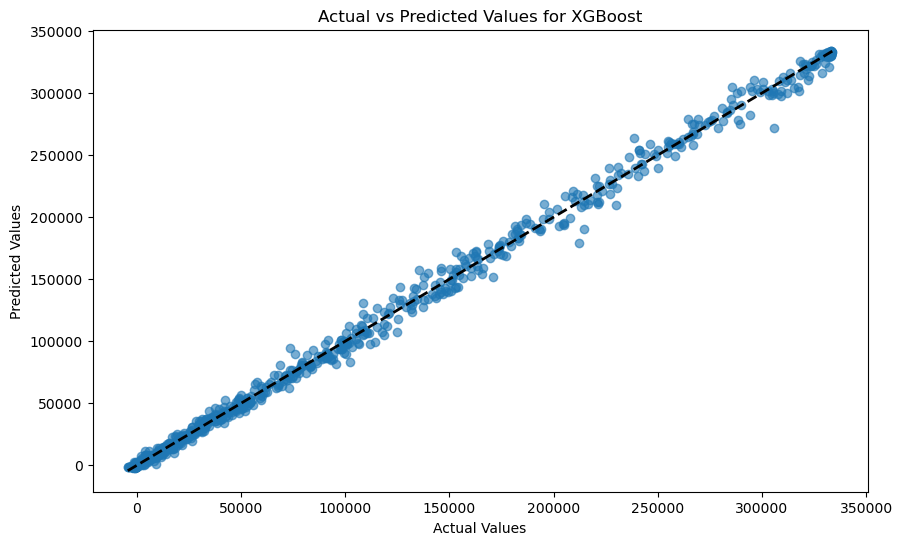

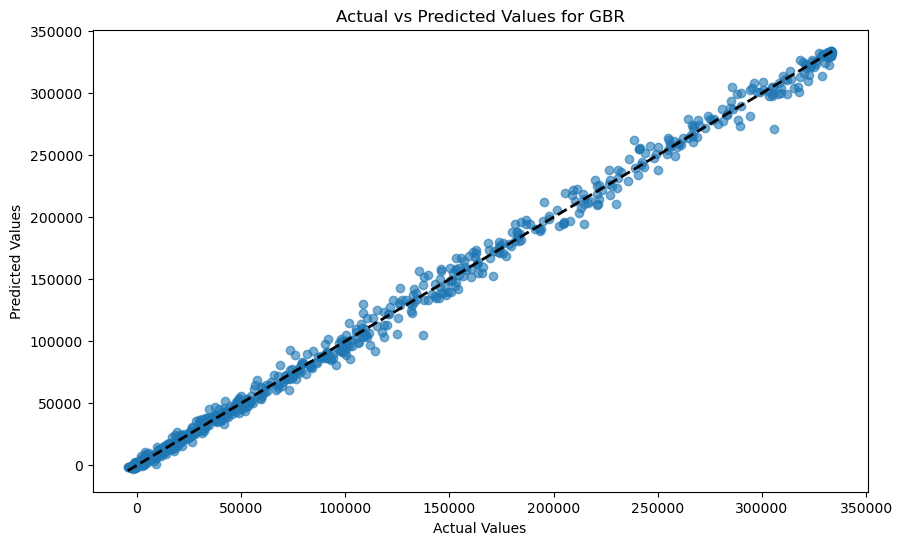

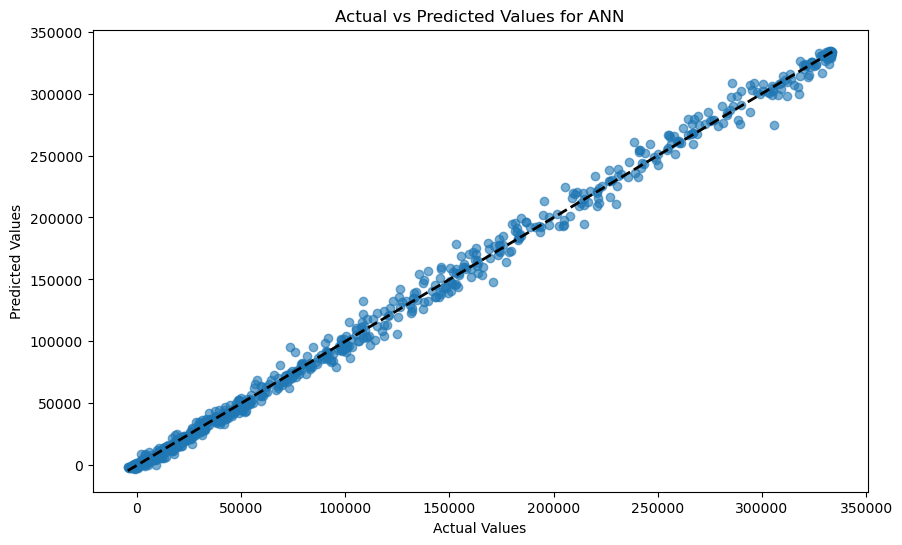

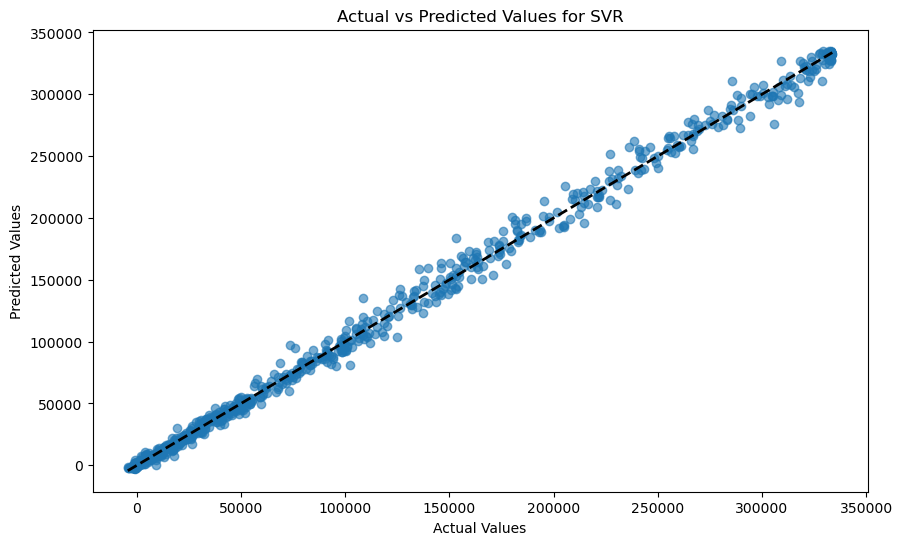

In [13]:
# Randomly select 1000 indices
np.random.seed(42)  # Ensures reproducibility
indices = np.random.choice(y_test.shape[0], 1000, replace=False)

# Subset y_test and predictions
y_test_subset = y_test.iloc[indices]
predictions_rf_subset = predictions_rf[indices]
predictions_xgb_subset = predictions_xgb[indices]
predictions_gbr_subset = predictions_gbr[indices]
predictions_ann_subset = predictions_ann[indices]
predictions_svr_subset = predictions_svr[indices]

# Function to create a scatter plot
def create_scatter_plot(predictions_subset, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_subset, predictions_subset, alpha=0.6)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {model_name}')
    plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], 'k--', lw=2)
    plt.show()

# Create scatter plots
create_scatter_plot(predictions_rf_subset, 'Random Forest')
create_scatter_plot(predictions_xgb_subset, 'XGBoost')
create_scatter_plot(predictions_gbr_subset, 'GBR')
create_scatter_plot(predictions_ann_subset, 'ANN')
create_scatter_plot(predictions_svr_subset, 'SVR')


Here feature importances are extracted and plotted. This was done very early in the analysis, just after the benchmarking using Random forest is done. But for the flow of the document it is placed here instead. 

                   Feature  Importance
0              Rtr_RPM_Avg    0.384054
1        Amb_WindSpeed_Avg    0.320960
4      Grd_Prod_CosPhi_Avg    0.150889
3      Blds_PitchAngle_Avg    0.106514
5  Amb_WindDir_Abs_Avg_sin    0.026084
6  Amb_WindDir_Abs_Avg_cos    0.009164
2             Amb_Temp_Avg    0.002335


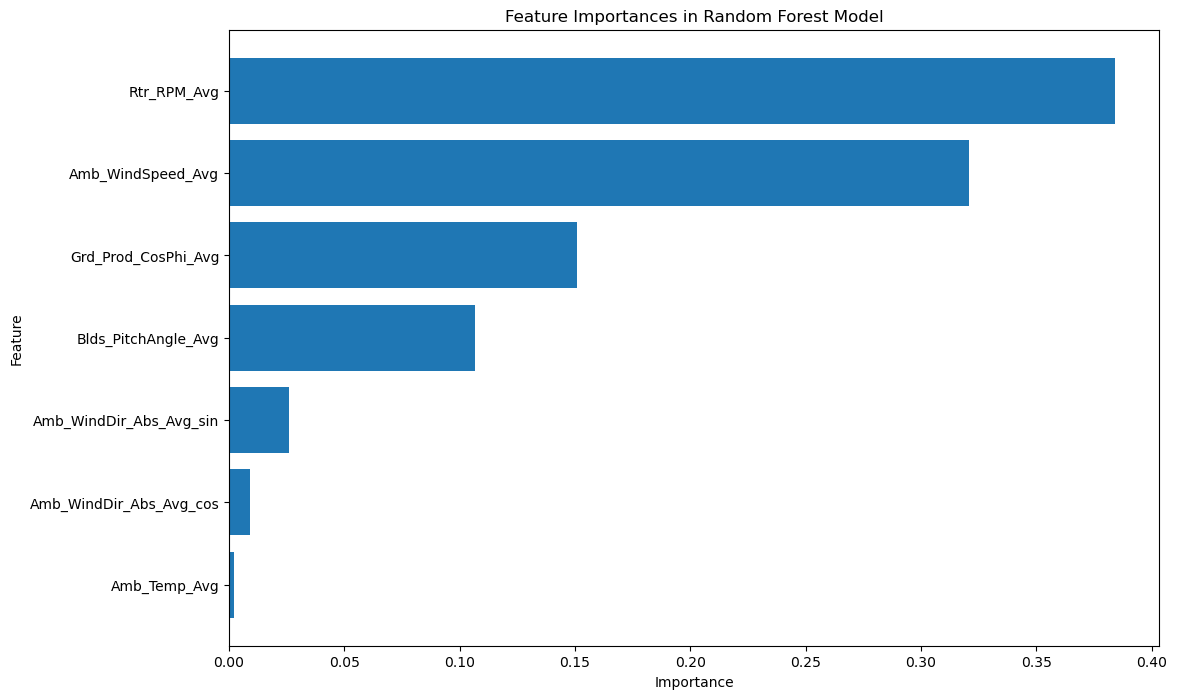

In [14]:
feature_importances = best_rf.feature_importances_

# Create a DataFrame for feature importances
features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features = features.sort_values(by='Importance', ascending=False)

# Print the feature importance table
print(features)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

Here a copy of all predictions and their subsets are saved as csv. This is important because it removes the need of training the models again, and further plotting can be done using the saved predictions. 

In [15]:
# Exporting y_test and all predictions
y_test.to_csv('y_test.csv', index=False)
pd.DataFrame(predictions_rf, columns=['predictions_rf']).to_csv('predictions_rf.csv', index=False)
pd.DataFrame(predictions_xgb, columns=['predictions_xgb']).to_csv('predictions_xgb.csv', index=False)
pd.DataFrame(predictions_gbr, columns=['predictions_gbr']).to_csv('predictions_gbr.csv', index=False)
pd.DataFrame(predictions_ann, columns=['predictions_ann']).to_csv('predictions_ann.csv', index=False)
pd.DataFrame(predictions_svr, columns=['predictions_svr']).to_csv('predictions_svr.csv', index=False)

# Exporting the subsets
# Assuming y_test_subset and prediction subsets are numpy arrays or pandas series
y_test_subset.to_csv('y_test_subset.csv', index=False)
pd.DataFrame(predictions_rf_subset, columns=['predictions_rf_subset']).to_csv('predictions_rf_subset.csv', index=False)
pd.DataFrame(predictions_xgb_subset, columns=['predictions_xgb_subset']).to_csv('predictions_xgb_subset.csv', index=False)
pd.DataFrame(predictions_gbr_subset, columns=['predictions_gbr_subset']).to_csv('predictions_gbr_subset.csv', index=False)
pd.DataFrame(predictions_ann_subset, columns=['predictions_ann_subset']).to_csv('predictions_ann_subset.csv', index=False)
pd.DataFrame(predictions_svr_subset, columns=['predictions_svr_subset']).to_csv('predictions_svr_subset.csv', index=False)